In [113]:
%load_ext autoreload
%autoreload 2
 
import sys
sys.path.append('../src')
import xgboost as xgb
import pandas as pd
import numpy as np
from features.UserJoin import UserJoin
from features.UserJoin import submit, diff, plt_month, plt_day, load_ids, info, infot
import config as C
import matplotlib.pyplot as plt

from xgb_search import exp
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
from xgboost import plot_tree
import random
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import itertools
sns.set_style("ticks",{'axes.grid' : True})

pd.options.display.max_columns = 500
pd.options.display.max_rows = 50
plt.style.use('ggplot')

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
ds = UserJoin()

In [11]:
# 节假日平均和非节假日平均的差值。
hol_diff_col = ['kwh_holiday_diff',
                'kwh_cal_holiday_diff',
                'kwh_pap_r2_holiday_diff',
                'kwh_pap_r3_holiday_diff',
                'kwh_pap_r4_holiday_diff',
                'pr2_holiday_diff',
                'pr3_holiday_diff',
                'pr4_holiday_diff',
                '2_3_holiday_diff',
                '2_4_holiday_diff',
                '3_4_holiday_diff',
                'daycv_holiday_diff']

# 节假日均值 和 非节假日的均值
hol_mean_col = ['kwh_holiday_mean_1',
                'kwh_cal_holiday_mean_1',
                'kwh_pap_r2_holiday_mean_1',
                'kwh_pap_r3_holiday_mean_1',
                'kwh_pap_r4_holiday_mean_1',
                'pr2_holiday_mean_1',
                'pr3_holiday_mean_1',
                'pr4_holiday_mean_1',
                '2_3_holiday_mean_1',
                '2_4_holiday_mean_1',
                '3_4_holiday_mean_1',
                'daycv_holiday_mean_1',
                'kwh_holiday_mean_0',
                'kwh_cal_holiday_mean_0',
                'kwh_pap_r2_holiday_mean_0',
                'kwh_pap_r3_holiday_mean_0',
                'kwh_pap_r4_holiday_mean_0',
                'pr2_holiday_mean_0',
                'pr3_holiday_mean_0',
                'pr4_holiday_mean_0',
                '2_3_holiday_mean_0',
                '2_4_holiday_mean_0',
                '3_4_holiday_mean_0',
                'daycv_holiday_mean_0',
                ]

# 节假日方差 和 非节假日的方差
hol_std_col = ['kwh_holiday_std_1',
               'kwh_cal_holiday_std_1',
               'kwh_pap_r2_holiday_std_1',
               'kwh_pap_r3_holiday_std_1',
               'kwh_pap_r4_holiday_std_1',
               'pr2_holiday_std_1',
               'pr3_holiday_std_1',
               'pr4_holiday_std_1',
               '2_3_holiday_std_1',
               '2_4_holiday_std_1',
               '3_4_holiday_std_1',
               'daycv_holiday_std_1',
               'kwh_holiday_std_0',
               'kwh_cal_holiday_std_0',
               'kwh_pap_r2_holiday_std_0',
               'kwh_pap_r3_holiday_std_0',
               'kwh_pap_r4_holiday_std_0',
               'pr2_holiday_std_0',
               'pr3_holiday_std_0',
               'pr4_holiday_std_0',
               '2_3_holiday_std_0',
               '2_4_holiday_std_0',
               '3_4_holiday_std_0',
               'daycv_holiday_std_0',
               ]

# 日基础数据
day_col = [
    'kwh',
    'kwh_cal',
    'kwh_pap_r2',
    'kwh_pap_r3',
    'kwh_pap_r4',
    'pr2',
    'pr3',
    'pr4',
    '2_3',
    '2_4',
    '3_4',
    'daycv',
]

user_col = [
    'ELEC_TYPE_NAME',
    'VOLT_NAME',
    'RUN_CAP',
    'ELEC_TYPE_NAME_CODE',
    'VOLT_NAME_CODE',
    'label'
]

month_col = [
    'pq_f',
    'pq_g',
    'pq_p',
    'pq_z',
    'pp',
    'pf',
    'pg',
    'p_f',
    'p_g',
    'f_g',
    'monthcv',
]


In [32]:
user = ds.train.reset_index()
user.loc[user.label == 'test', 'label'] = -1
user.label = user.label.astype('int')

<AxesSubplot:>

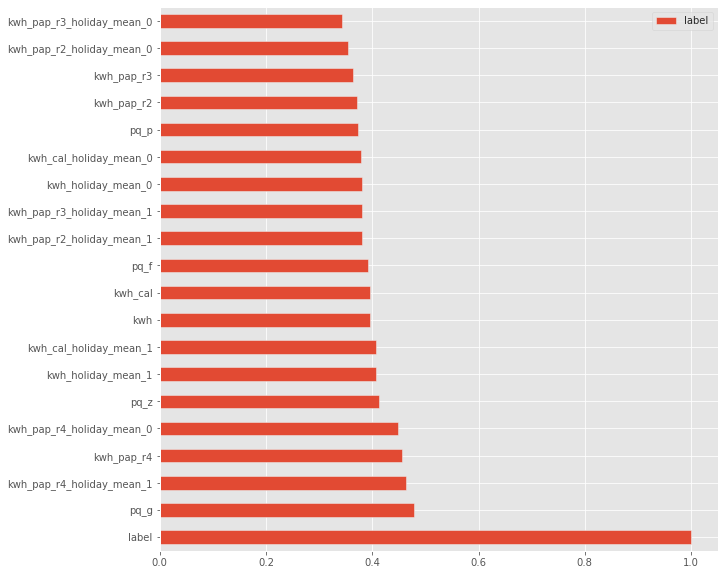

In [59]:
user[(user.label != -1) & (user.id.isin(ds.train2.index.values))].corr()[['label']].sort_values('label', ascending=False).head(20).plot(kind='barh',figsize=(10, 10))

In [62]:
user['isminer'] = user.label
user.loc[user.id.isin(C.true_ids), 'isminer'] = 1
user.loc[user.id.isin(C.false_ids), 'isminer'] = 0
user = user[user.isminer != -1]

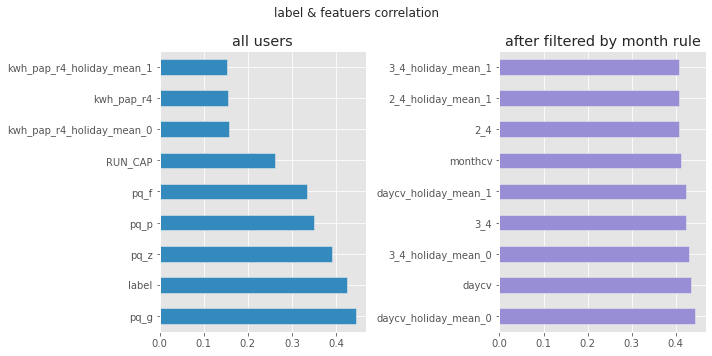

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
user.corr().sort_values('isminer').isminer \
    .map(lambda x: abs(x)).sort_values(ascending=False) \
    .head(10).drop('isminer').plot(kind='barh', ax=axs[0], title='all users', color=color_pal[1])

user[user.id.isin(ds.train2.index.values)].corr().sort_values('isminer').isminer \
    .map(lambda x: abs(x)).sort_values(ascending=False) \
    .head(10).drop('isminer').plot(kind='barh', ax=axs[1], title='after filtered by month rule', color=color_pal[2])

plt.suptitle('label & featuers correlation')
plt.tight_layout()
plt.show()

In [92]:
user[day_col].head(5)

,kwh,kwh_cal,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4,pr2,pr3,pr4,2_3,2_4,3_4,daycv
0,17.723178,17.722804,11.790935,0.0,5.931869,0.657183,0.0,0.342817,0.657183,0.340257,0.342817,1.040713
1,34.517944,34.518131,23.671495,0.0,10.846636,0.681968,0.0,0.308686,0.681968,0.373281,0.308686,1.035656
2,54.653271,54.653271,43.415701,0.0,11.237570,0.785142,0.0,0.205512,0.785142,0.579631,0.205512,1.226316
3,34.197757,34.198037,24.496355,0.0,9.701682,0.717844,0.0,0.272810,0.717844,0.445033,0.272810,1.096507
4,33.965234,33.965234,24.343832,0.0,9.621402,0.711382,0.0,0.279272,0.711382,0.432110,0.279272,1.085375


In [93]:
user[month_col].head(5)

,pq_f,pq_g,pq_p,pq_z,pp,pf,pg,p_f,p_g,f_g,monthcv
0,444.809524,250.238095,0.095238,695.142857,0.000260,0.648618,0.351122,0.648359,0.350862,0.297497,0.983860
1,670.333333,310.714286,0.000000,981.047619,0.000025,0.687396,0.312579,0.687372,0.312554,0.374817,1.036359
2,95.952381,31.000000,1505.523810,1632.476190,0.928215,0.054251,0.017534,0.945596,0.934286,0.036717,1.649252
3,723.095238,302.238095,0.095238,1025.428571,0.000075,0.711996,0.287929,0.711921,0.287854,0.424066,1.078630
4,0.000000,0.000000,1130.952381,1130.952381,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.732051


In [94]:
user[hol_diff_col + hol_std_col + hol_mean_col].head(5)

,kwh_holiday_diff,kwh_cal_holiday_diff,kwh_pap_r2_holiday_diff,kwh_pap_r3_holiday_diff,kwh_pap_r4_holiday_diff,pr2_holiday_diff,pr3_holiday_diff,pr4_holiday_diff,2_3_holiday_diff,2_4_holiday_diff,3_4_holiday_diff,daycv_holiday_diff,kwh_holiday_std_1,kwh_cal_holiday_std_1,kwh_pap_r2_holiday_std_1,kwh_pap_r3_holiday_std_1,kwh_pap_r4_holiday_std_1,pr2_holiday_std_1,pr3_holiday_std_1,pr4_holiday_std_1,2_3_holiday_std_1,2_4_holiday_std_1,3_4_holiday_std_1,daycv_holiday_std_1,kwh_holiday_std_0,kwh_cal_holiday_std_0,kwh_pap_r2_holiday_std_0,kwh_pap_r3_holiday_std_0,kwh_pap_r4_holiday_std_0,pr2_holiday_std_0,pr3_holiday_std_0,pr4_holiday_std_0,2_3_holiday_std_0,2_4_holiday_std_0,3_4_holiday_std_0,daycv_holiday_std_0,kwh_holiday_mean_1,kwh_cal_holiday_mean_1,kwh_pap_r2_holiday_mean_1,kwh_pap_r3_holiday_mean_1,kwh_pap_r4_holiday_mean_1,pr2_holiday_mean_1,pr3_holiday_mean_1,pr4_holiday_mean_1,2_3_holiday_mean_1,2_4_holiday_mean_1,3_4_holiday_mean_1,daycv_holiday_mean_1,kwh_holiday_mean_0,kwh_cal_holiday_mean_0,kwh_pap_r2_holiday_mean_0,kwh_pap_r3_holiday_mean_0,kwh_pap_r4_holiday_mean_0,pr2_holiday_mean_0,pr3_holiday_mean_0,pr4_holiday_mean_0,2_3_holiday_mean_0,2_4_holiday_mean_0,3_4_holiday_mean_0,daycv_holiday_mean_0
0,-3.998463,-3.998414,-1.315660,0.0,-2.682754,0.047577,0.0,-0.047577,0.047577,0.103534,-0.047577,0.086607,10.017607,10.016824,7.360038,0.0,3.586769,0.133760,0.0,0.133760,0.133760,0.221112,0.133760,0.171637,11.330924,11.330985,7.184303,0.0,5.044812,0.108691,0.0,0.108691,0.108691,0.187768,0.108691,0.147897,15.854737,15.854386,11.176140,0.0,4.678246,0.679416,0.0,0.320584,0.679416,0.388637,0.320584,1.081183,19.8532,19.8528,12.4918,0.0,7.3610,0.631839,0.0,0.368161,0.631839,0.285103,0.368161,0.994577
1,1.113070,1.114172,0.766074,0.0,0.348098,0.012451,0.0,0.007549,0.012451,0.004902,0.007549,0.018941,7.866967,7.867479,5.596144,0.0,3.567322,0.061247,0.0,0.061247,0.061247,0.122494,0.061247,0.098560,9.007026,9.007118,6.112239,0.0,4.041063,0.115767,0.0,0.076402,0.115767,0.135935,0.076402,0.183775,35.038070,35.038772,24.029474,0.0,11.009298,0.687786,0.0,0.312214,0.687786,0.375572,0.312214,1.044507,33.9250,33.9246,23.2634,0.0,10.6612,0.675335,0.0,0.304665,0.675335,0.370670,0.304665,1.025566
2,6.051077,6.051077,5.619754,0.0,0.431323,0.029755,0.0,-0.009755,0.029755,0.039511,-0.009755,0.053295,11.140191,11.140303,9.604320,0.0,2.989363,0.048753,0.0,0.048753,0.048753,0.097507,0.048753,0.102513,11.604136,11.604127,9.766064,0.0,3.585315,0.123253,0.0,0.061576,0.123253,0.134036,0.061576,0.206085,57.480877,57.480877,46.041754,0.0,11.439123,0.799047,0.0,0.200953,0.799047,0.598094,0.200953,1.251220,51.4298,51.4298,40.4220,0.0,11.0078,0.769291,0.0,0.210709,0.769291,0.558583,0.210709,1.197925
3,3.301526,3.301677,2.563786,0.0,0.737891,0.018366,0.0,0.001634,0.018366,0.016732,0.001634,0.029309,11.559368,11.558478,7.479899,0.0,4.574263,0.062117,0.0,0.062117,0.062117,0.124235,0.062117,0.114959,11.264031,11.265687,7.238206,0.0,4.586592,0.119100,0.0,0.072693,0.119100,0.137615,0.072693,0.192661,35.740526,35.740877,25.694386,0.0,10.046491,0.726426,0.0,0.273574,0.726426,0.452852,0.273574,1.110203,32.4390,32.4392,23.1306,0.0,9.3086,0.708060,0.0,0.271940,0.708060,0.436120,0.271940,1.080894
4,-0.504151,-0.504151,0.614277,0.0,-1.118428,0.043413,0.0,-0.023413,0.043413,0.066827,-0.023413,0.069268,7.547061,7.547061,5.817594,0.0,2.805502,0.055268,0.0,0.055268,0.055268,0.110536,0.055268,0.104317,8.840746,8.840746,6.784717,0.0,3.443882,0.120011,0.0,0.079440,0.120011,0.146379,0.079440,0.193496,33.729649,33.729649,24.630877,0.0,9.098772,0.731669,0.0,0.268331,0.731669,0.463338,0.268331,1.117743,34.2338,34.2338,24.0166,0.0,10.2172,0.688256,0.0,0.291744,0.688256,0.396511,0.291744,1.048475


In [95]:
user[user_col].head(5)

,ELEC_TYPE_NAME,VOLT_NAME,RUN_CAP,ELEC_TYPE_NAME_CODE,VOLT_NAME_CODE,label
0,乡村居民生活用电,交流220V,4.0,0,1,0
1,乡村居民生活用电,交流220V,4.0,0,1,0
2,乡村居民生活用电,交流220V,8.0,0,1,0
3,乡村居民生活用电,交流220V,2.0,0,1,0
4,乡村居民生活用电,交流220V,8.0,0,1,0
